In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
from joblib import dump
from joblib import load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from os import listdir

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from pydlts.fsmodels import SklMultiExpFrequencyScan
from pydlts.fsplots import plot_spectr
from pydlts.fsplots import plot_model
from pydlts.fsplots import plot_loss_path
from pydlts.fsplots import plot_deviations

%matplotlib inline

In [3]:
DATASETS_PATH = '../../../datasets/'
SAVES_PATH = 'saves_6_exps/'

file_names = listdir(DATASETS_PATH)

u1 = -4
ur = -5

data_frames = [[file_name, pd.read_csv(DATASETS_PATH + file_name, parse_dates=[0])] for file_name in file_names]

condition = lambda frame: frame.loc[0, 'u1']==u1 and frame.loc[0, 'ur']==ur
data_frames = [[name, frame] for [name, frame] in data_frames if condition(frame)]

key_func = lambda x: x[1].temperature_k.iloc[0]
data_frames.sort(key=key_func)

for i, item in enumerate(data_frames):
    print(f'{i}.', item[0])

0. 1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv
1. 1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01.csv
2. 1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1.csv


In [4]:
def get_X_y(dataset):
    filling_pulse = dataset.f_pulse[0] * 10 ** -6
    
    df = dataset.sample(frac=1, random_state=42)
    
    X_train = np.log10(df.frequency_hz.to_numpy())
    y_train = df.dlts_pf.to_numpy()
    
    return filling_pulse, X_train, y_train

In [5]:
def display_scores(scores):
    print('Scores - корни из среднеквадратических ошибок')
    scores = np.sqrt(-scores)
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

Загружаем модель для 263 К

In [6]:
filling_pulse, X_train, y_train = get_X_y(data_frames[0][1])
mean_temp_263 = data_frames[0][1].temperature_k.mean()

Идентификация модели для 263 К

In [7]:
model_263K_6_exp = SklMultiExpFrequencyScan(filling_pulse=filling_pulse,
                                            n_exps=6,
                                            learning_rate = 0.05,
                                            stop_val = 10**-6,
                                           )

model_263K_6_exp.fit(X_train, y_train)
model_263K_6_exp.fit_results_.tail()

2022-10-14 22:33:49.272380: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-14 22:33:49.272400: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-14 22:33:49.272404: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-14 22:33:49.272514: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.76.0
2022-10-14 22:33:49.272526: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-14 22:33:49.272529: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.65.1 does not match DSO version 515.76.0 -- cannot find working devices in this configuration
2022-10-14 22:33:49.272686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,verbose
995,0.0002,0.000253,0.000258,-0.000294,0.000028,-0.000338,0.00001,0.05,1.714330e-08,6,1000,0.000001,-2.886781,-3.592145,-3.886029,-1.622826,-2.402829,-0.672279,False
996,0.0002,0.000253,0.000258,-0.000294,0.000028,-0.000338,0.00001,0.05,1.714317e-08,6,1000,0.000001,-2.886905,-3.592184,-3.886213,-1.622772,-2.402839,-0.672232,False
997,0.0002,0.000253,0.000258,-0.000294,0.000028,-0.000338,0.00001,0.05,1.714305e-08,6,1000,0.000001,-2.887028,-3.592223,-3.886398,-1.622718,-2.402850,-0.672184,False
998,0.0002,0.000253,0.000258,-0.000294,0.000028,-0.000338,0.00001,0.05,1.714292e-08,6,1000,0.000001,-2.887151,-3.592263,-3.886582,-1.622663,-2.402860,-0.672136,False
999,0.0002,0.000253,0.000258,-0.000294,0.000028,-0.000338,0.00001,0.05,1.714279e-08,6,1000,0.000001,-2.887274,-3.592302,-3.886766,-1.622609,-2.402870,-0.672089,False


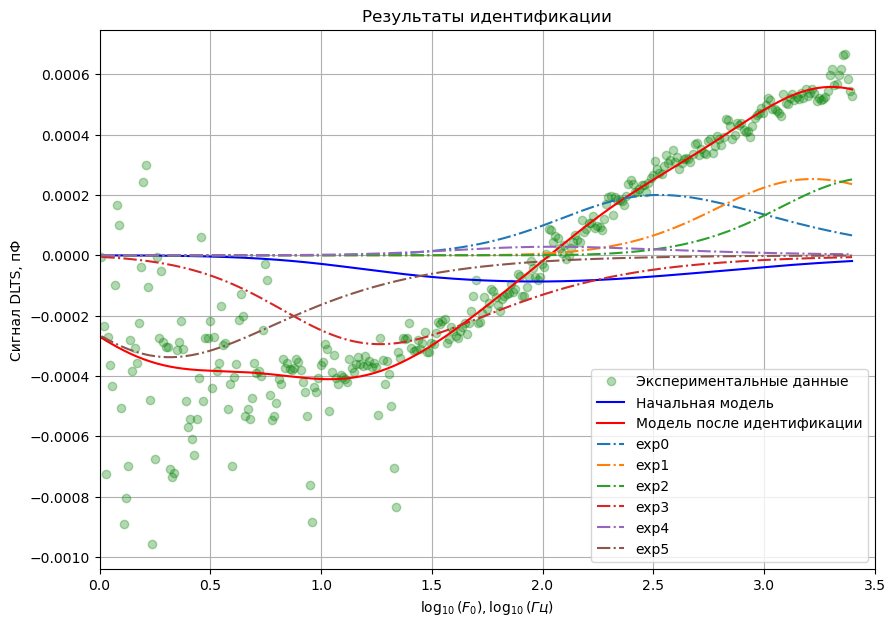

In [8]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, model_263K_6_exp.fit_results_)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(SAVES_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_model.pdf',
            bbox_inches='tight')
plt.show()

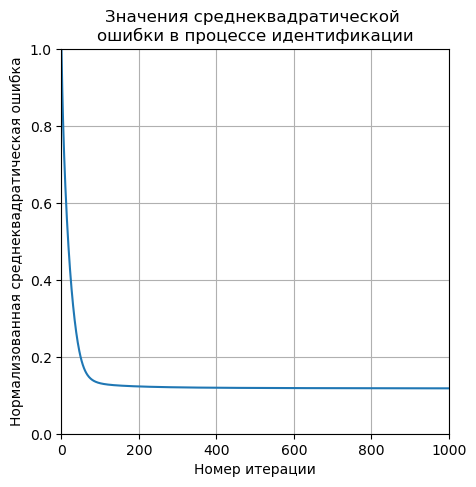

In [9]:
plot_loss_path(model_263K_6_exp.fit_results_)
plt.savefig(SAVES_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_loss.pdf',
            bbox_inches='tight')
plt.show()

In [10]:
y_pred = model_263K_6_exp.predict(X_train)

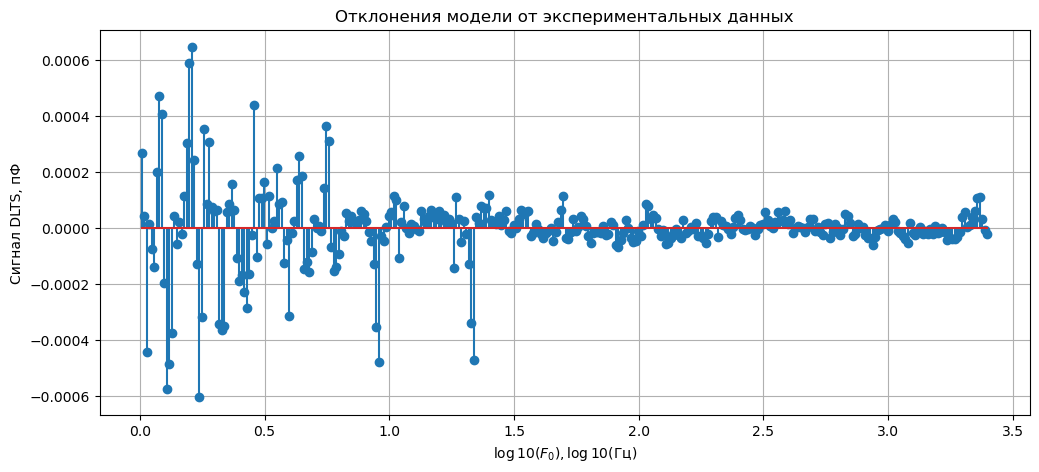

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, y_pred, ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(SAVES_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

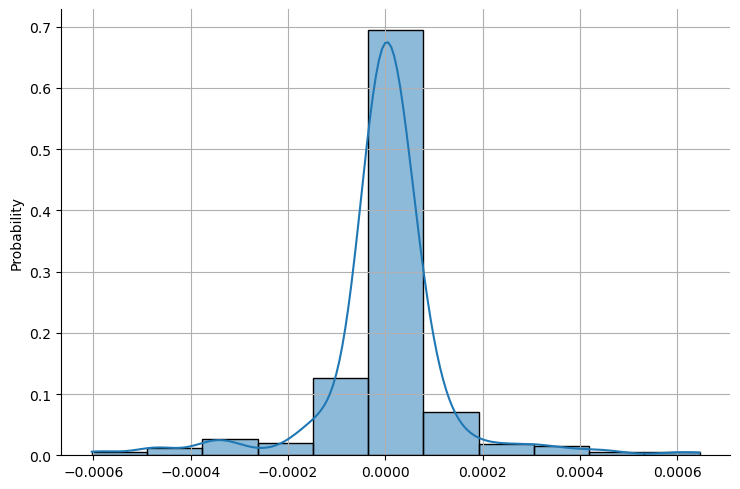

In [12]:
sns.displot(x=y_train - y_pred, bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(SAVES_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

In [13]:
scores = cross_val_score(model_263K_6_exp, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

2022-10-14 22:46:04.525688: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-14 22:46:04.525710: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-14 22:46:04.525714: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-14 22:46:04.525817: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.76.0
2022-10-14 22:46:04.525830: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-14 22:46:04.525833: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.65.1 does not match DSO version 515.76.0 -- cannot find working devices in this configuration
2022-10-14 22:46:04.525936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI

In [14]:
display_scores(scores)

Scores - корни из среднеквадратических ошибок
Scores: [0.0001848  0.00010057 0.00012414 0.00013446 0.00011041]
Mean: 0.00013087775354066427
Standard deviation: 2.933721849414766e-05


In [15]:
mean_squared_error(y_train, y_pred, squared=False)

0.000130929977824229

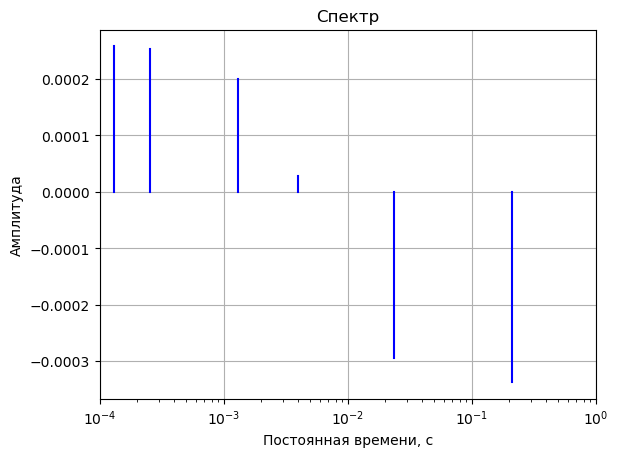

In [16]:
plot_spectr(model_263K_6_exp.exps_params_, xlim=[1/10000, 1])
plt.savefig(SAVES_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()

Загружаем модель для 283 К

In [17]:
filling_pulse, X_train, y_train = get_X_y(data_frames[1][1])
mean_temp_283 = data_frames[1][1].temperature_k.mean()

In [18]:
model_283K_6_exp = SklMultiExpFrequencyScan(filling_pulse=filling_pulse,
                                            n_exps=6,
                                            learning_rate = 0.05,
                                            stop_val = 10**-6,
                                           )

model_283K_6_exp.fit(X_train, y_train)

model_283K_6_exp.fit_results_.tail()

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,verbose
860,0.002546,0.000605,0.000918,0.002055,0.000374,0.001652,0.00001,0.05,1.999300e-08,6,1000,0.000001,-0.622489,-2.880179,-3.776610,-1.417517,-3.022831,-2.221535,False
861,0.002546,0.000605,0.000919,0.002055,0.000374,0.001652,0.00001,0.05,1.999155e-08,6,1000,0.000001,-0.622508,-2.880151,-3.776679,-1.417491,-3.022837,-2.221495,False
862,0.002546,0.000605,0.000919,0.002055,0.000374,0.001652,0.00001,0.05,1.999012e-08,6,1000,0.000001,-0.622527,-2.880123,-3.776749,-1.417465,-3.022844,-2.221455,False
863,0.002546,0.000605,0.000919,0.002055,0.000374,0.001652,0.00001,0.05,1.998868e-08,6,1000,0.000001,-0.622546,-2.880095,-3.776819,-1.417439,-3.022850,-2.221415,False
864,0.002546,0.000605,0.000919,0.002055,0.000374,0.001652,0.00001,0.05,1.998725e-08,6,1000,0.000001,-0.622564,-2.880067,-3.776888,-1.417413,-3.022857,-2.221375,False


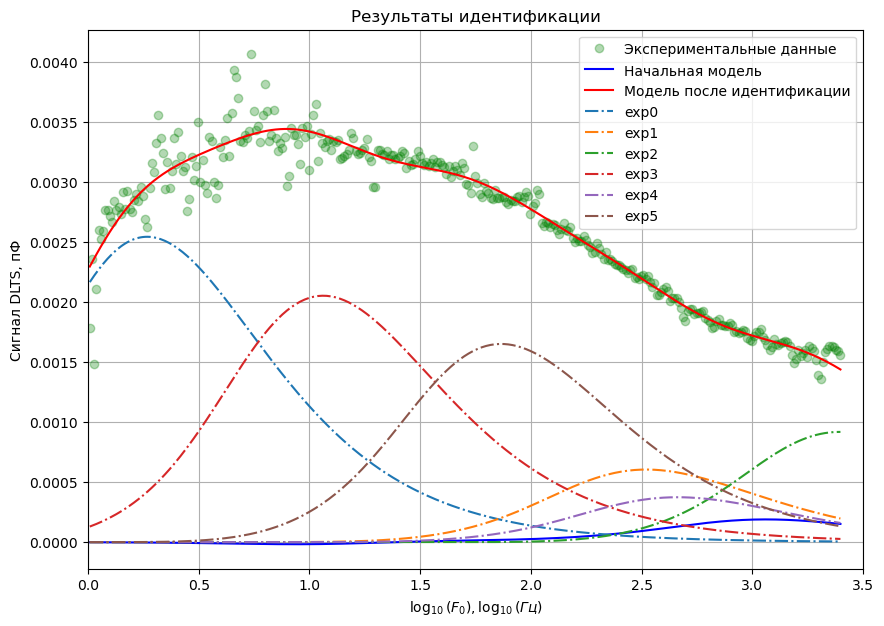

In [19]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, model_283K_6_exp.fit_results_)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(SAVES_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_model.pdf',
            bbox_inches='tight')
plt.show()

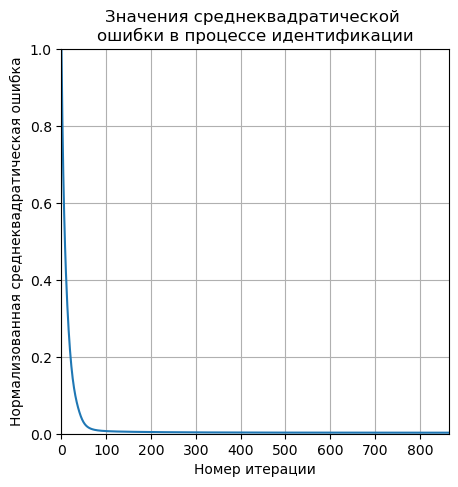

In [20]:
plot_loss_path(model_283K_6_exp.fit_results_)
plt.savefig(SAVES_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_loss.pdf',
            bbox_inches='tight')
plt.show()

In [21]:
y_pred = model_283K_6_exp.predict(X_train)

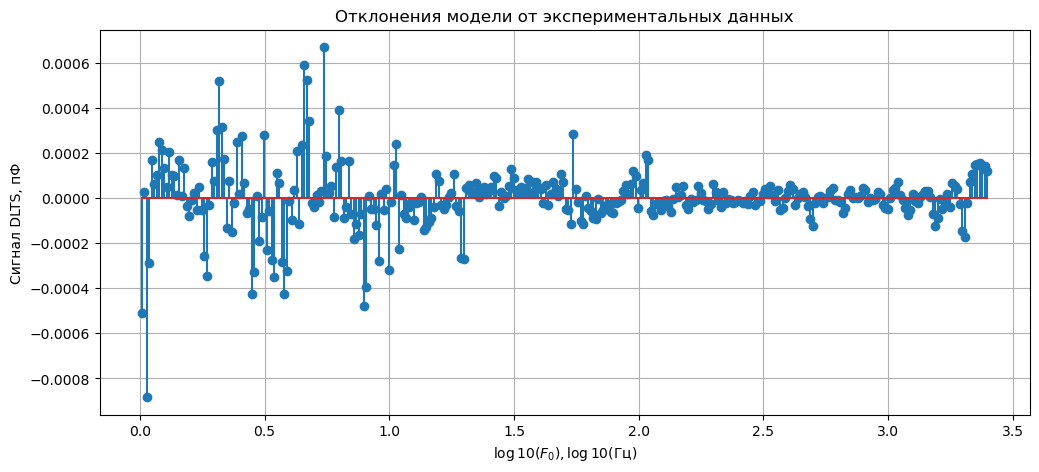

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, y_pred, ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(SAVES_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

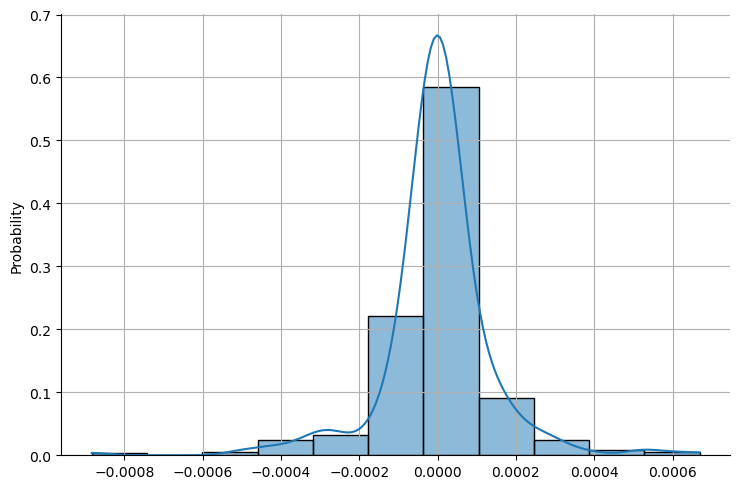

In [23]:
sns.displot(x=y_train - y_pred, bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(SAVES_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

In [27]:
mean_squared_error(y_train, y_pred, squared=False)

0.0001413762879779115

In [28]:
scores = cross_val_score(model_283K_6_exp, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

2022-10-14 23:33:26.970969: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-14 23:33:26.971000: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-14 23:33:26.971004: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-14 23:33:26.971134: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.76.0
2022-10-14 23:33:26.971147: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-14 23:33:26.971151: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.65.1 does not match DSO version 515.76.0 -- cannot find working devices in this configuration
2022-10-14 23:33:26.971284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI

In [29]:
display_scores(scores)

Scores - корни из среднеквадратических ошибок
Scores: [0.00016959 0.00012831 0.00014561 0.00014884 0.00015816]
Mean: 0.00015010277579294114
Standard deviation: 1.3719010657930188e-05


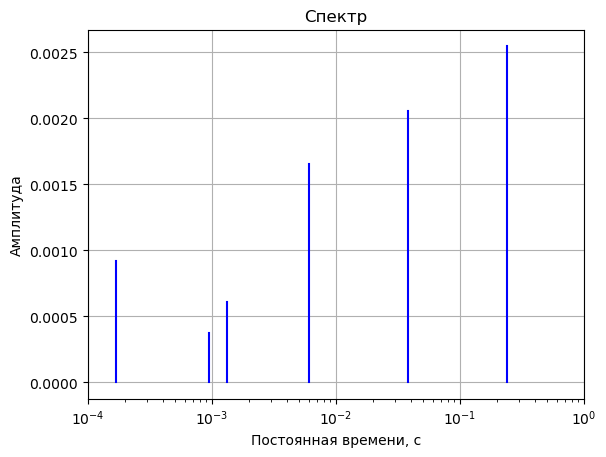

In [30]:
plot_spectr(model_283K_6_exp.exps_params_, xlim=[1/10000, 1])
plt.savefig(SAVES_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()

Загружаем модель для 303 К

In [31]:
filling_pulse, X_train, y_train = get_X_y(data_frames[2][1])
mean_temp_303 = data_frames[2][1].temperature_k.mean()

In [32]:
model_303K_6_exp = SklMultiExpFrequencyScan(filling_pulse=filling_pulse,
                                            n_exps=6,
                                            learning_rate = 0.05,
                                            stop_val = 10**-6,
                                           )

model_303K_6_exp.fit(X_train, y_train)

model_303K_6_exp.fit_results_.tail()

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,verbose
821,0.004753,0.004768,0.006810,0.005923,0.007874,0.006421,0.00001,0.05,6.375026e-08,6,1000,0.000001,-3.581511,-2.772324,-1.715209,-2.423765,-1.739093,-0.738411,False
822,0.004752,0.004768,0.006811,0.005923,0.007874,0.006420,0.00001,0.05,6.371908e-08,6,1000,0.000001,-3.581604,-2.772365,-1.715185,-2.423790,-1.739058,-0.738311,False
823,0.004752,0.004769,0.006811,0.005924,0.007875,0.006420,0.00001,0.05,6.368804e-08,6,1000,0.000001,-3.581696,-2.772407,-1.715162,-2.423815,-1.739024,-0.738212,False
824,0.004752,0.004769,0.006812,0.005924,0.007875,0.006419,0.00001,0.05,6.365716e-08,6,1000,0.000001,-3.581788,-2.772449,-1.715138,-2.423839,-1.738989,-0.738112,False
825,0.004751,0.004769,0.006812,0.005924,0.007875,0.006419,0.00001,0.05,6.362643e-08,6,1000,0.000001,-3.581880,-2.772491,-1.715114,-2.423864,-1.738955,-0.738013,False


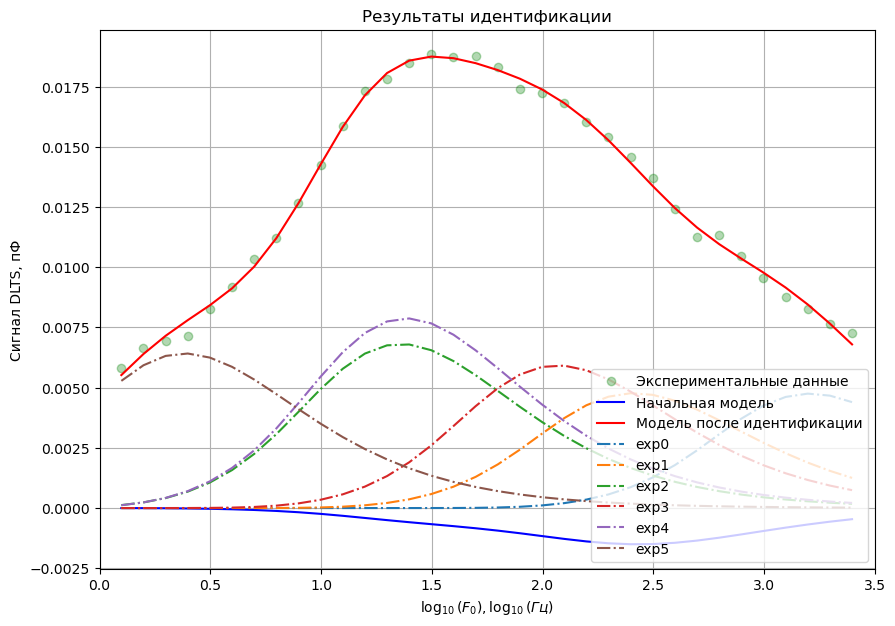

In [33]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, model_303K_6_exp.fit_results_)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.legend(loc='lower right')
plt.savefig(SAVES_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_model.pdf',
            bbox_inches='tight')
plt.show()

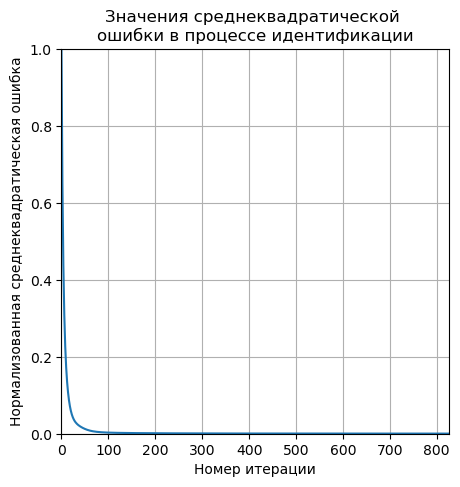

In [34]:
plot_loss_path(model_303K_6_exp.fit_results_)
plt.savefig(SAVES_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_loss.pdf',
            bbox_inches='tight')
plt.show()

In [39]:
y_pred = model_303K_6_exp.predict(X_train)

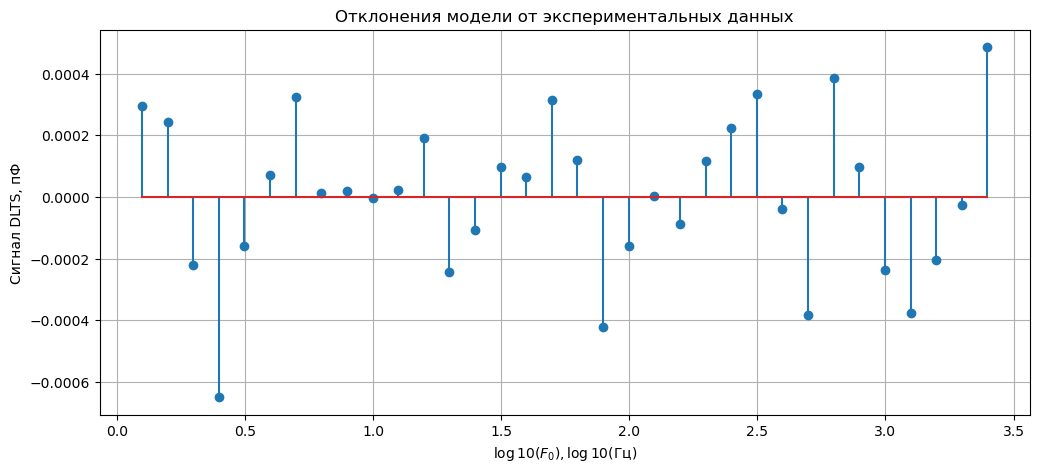

In [40]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, y_pred, ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(SAVES_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

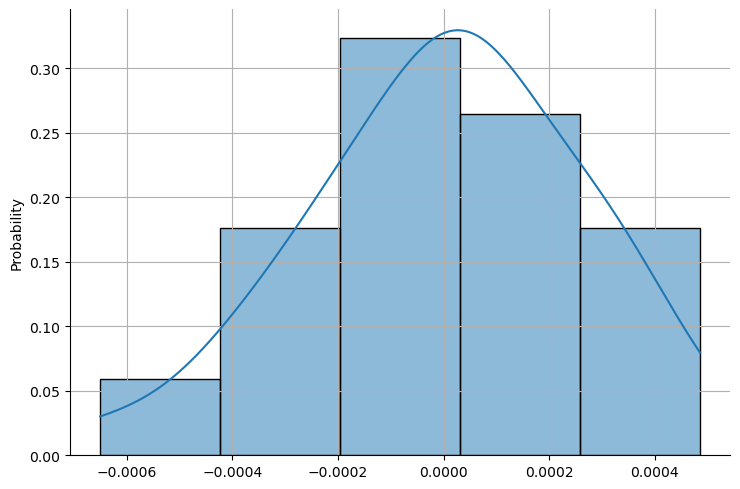

In [41]:
sns.displot(x=y_train - y_pred, bins=5, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(SAVES_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

In [42]:
scores = cross_val_score(model_303K_6_exp, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

2022-10-14 23:57:43.506895: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-14 23:57:43.506919: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-14 23:57:43.506923: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-14 23:57:43.507025: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.76.0
2022-10-14 23:57:43.507038: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-14 23:57:43.507041: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.65.1 does not match DSO version 515.76.0 -- cannot find working devices in this configuration
2022-10-14 23:57:43.507150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI

In [43]:
display_scores(scores)

Scores - корни из среднеквадратических ошибок
Scores: [0.00027675 0.00046624 0.00049633 0.00027446 0.00036721]
Mean: 0.0003761997850226343
Standard deviation: 9.258589691182493e-05


In [44]:
mean_squared_error(y_train, y_pred, squared=False)

0.0002522427940479556

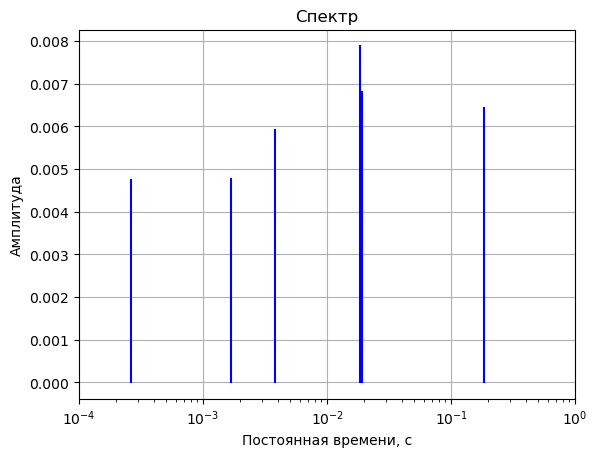

In [45]:
plot_spectr(model_303K_6_exp.exps_params_, xlim=[1/10000, 1])
plt.savefig(SAVES_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()

In [46]:
f_name = SAVES_PATH + 'model_263K_6_exp.pkl'

# для сохранения модели
dump(model_263K_6_exp, f_name)

# для загрузки модели:
# model_263K_6_exp = load(f_name)

['saves_6_expsmodel_263K_6_exp.pkl']

In [47]:
f_name = SAVES_PATH + 'model_283K_6_exp.pkl'

# для сохранения модели
dump(model_283K_6_exp, f_name)

# для загрузки модели:
# model_283K_6_exp = load(f_name)

['saves_6_expsmodel_283K_6_exp.pkl']

In [48]:
f_name = SAVES_PATH + 'model_303K_6_exp.pkl'

# для сохранения модели
dump(model_303K_6_exp, f_name)

# для загрузки модели:
# model_283K_6_exp = load(f_name)

['saves_6_expsmodel_303K_6_exp.pkl']

Перенос параметров в координаты Аррениуса

In [177]:
params_263 = np.stack([model_263K_6_exp.exps_params_[:, 1], 
                       np.repeat(mean_temp_263, model_263K_6_exp.exps_params_.shape[0])], 
                      axis=-1)

params_263 = params_263[np.argsort(params_263[:,0]), :]

params_263

array([[-3.37613796e-04,  2.62932356e+02],
       [-2.94466357e-04,  2.62932356e+02],
       [ 2.84451333e-05,  2.62932356e+02],
       [ 2.00176902e-04,  2.62932356e+02],
       [ 2.52919873e-04,  2.62932356e+02],
       [ 2.57833327e-04,  2.62932356e+02]])

In [178]:
params_283 = np.stack([model_283K_6_exp.exps_params_[:, 1], 
                       np.repeat(mean_temp_283, model_283K_6_exp.exps_params_.shape[0])], 
                      axis=-1)

params_283 = params_283[np.argsort(params_283[:,0]), :]

params_283

array([[3.74311550e-04, 2.83188647e+02],
       [6.05197099e-04, 2.83188647e+02],
       [9.18947486e-04, 2.83188647e+02],
       [1.65235072e-03, 2.83188647e+02],
       [2.05450532e-03, 2.83188647e+02],
       [2.54588103e-03, 2.83188647e+02]])

In [179]:
params_303 = np.stack([model_303K_6_exp.exps_params_[:, 1], 
                       np.repeat(mean_temp_303, model_303K_6_exp.exps_params_.shape[0])], 
                      axis=-1)

params_303 = params_303[np.argsort(params_303[:,0]), :]

params_303

array([[4.75122551e-03, 3.03271706e+02],
       [4.76927272e-03, 3.03271706e+02],
       [5.92401066e-03, 3.03271706e+02],
       [6.41865617e-03, 3.03271706e+02],
       [6.81196987e-03, 3.03271706e+02],
       [7.87533927e-03, 3.03271706e+02]])

Подготовим данные для регрессий

In [180]:
arrhenius_params = np.r_[params_263, params_283, params_303]

arrhenius_params[:, 0] = np.power(10, arrhenius_params[:, 0])
arrhenius_params[:, 0] = np.log(1 / ( arrhenius_params[:, 0] * np.power(arrhenius_params[:, 1], 2) ))

arrhenius_params[:, 1] = 1000 / arrhenius_params[:, 1]

arrhenius_params

array([[-11.14301621,   3.80325957],
       [-11.14311556,   3.80325957],
       [-11.14385909,   3.80325957],
       [-11.14425452,   3.80325957],
       [-11.14437596,   3.80325957],
       [-11.14438728,   3.80325957],
       [-11.29308843,   3.53121501],
       [-11.29362006,   3.53121501],
       [-11.2943425 ,   3.53121501],
       [-11.29603122,   3.53121501],
       [-11.29695722,   3.53121501],
       [-11.29808865,   3.53121501],
       [-11.44019835,   3.29737322],
       [-11.4402399 ,   3.29737322],
       [-11.44289878,   3.29737322],
       [-11.44403775,   3.29737322],
       [-11.44494339,   3.29737322],
       [-11.44739188,   3.29737322]])

In [181]:
regr_points = arrhenius_params.reshape(3,6,2).transpose(1,0,2)
regr_points

array([[[-11.14301621,   3.80325957],
        [-11.29308843,   3.53121501],
        [-11.44019835,   3.29737322]],

       [[-11.14311556,   3.80325957],
        [-11.29362006,   3.53121501],
        [-11.4402399 ,   3.29737322]],

       [[-11.14385909,   3.80325957],
        [-11.2943425 ,   3.53121501],
        [-11.44289878,   3.29737322]],

       [[-11.14425452,   3.80325957],
        [-11.29603122,   3.53121501],
        [-11.44403775,   3.29737322]],

       [[-11.14437596,   3.80325957],
        [-11.29695722,   3.53121501],
        [-11.44494339,   3.29737322]],

       [[-11.14438728,   3.80325957],
        [-11.29808865,   3.53121501],
        [-11.44739188,   3.29737322]]])

In [182]:
x = np.linspace(3, 4, 100).reshape(-1, 1)

Выполним линейные регрессии

In [183]:
lin_regr = LinearRegression()

In [184]:
lin_regr_pred = list()

In [185]:
for params in regr_points:
    lin_regr.fit(X=params[:, 1].reshape(-1, 1), y=params[:, 0].reshape(-1, 1))
    lin_regr_pred.append(lin_regr.predict(x))

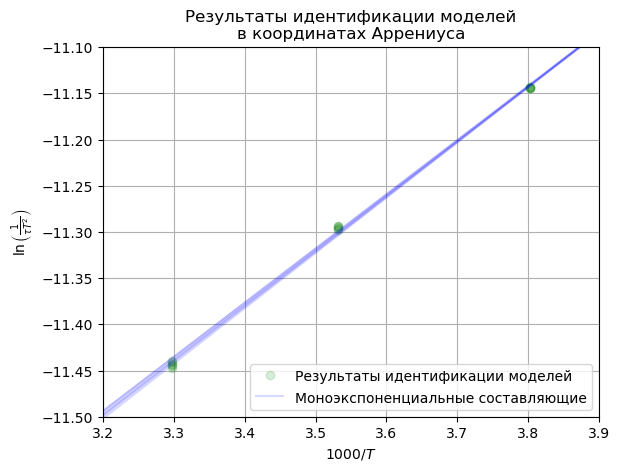

In [186]:
plt.plot(arrhenius_params[:, 1], 
         arrhenius_params[:, 0], 
         'og', 
         alpha=0.15, 
         label='Результаты идентификации моделей')

plt.plot(x, lin_regr_pred[0], '-b', alpha=0.15, label='Моноэкспоненциальные составляющие')
for y in lin_regr_pred[1:]:
    plt.plot(x, y, '-b', alpha=0.15)

plt.title('Результаты идентификации моделей\nв координатах Аррениуса')
plt.xlabel(r'$1000/T$')
plt.ylabel(r'$\ln\left(\frac{1}{\tau T^2}\right)$')

plt.xlim([3.2, 3.9])
plt.ylim([-11.5, -11.1])

plt.legend(loc='lower right')
plt.grid()

# plt.savefig(SAVES_PATH + 'arrhenius_individual_exps_lin_regr.pdf',
#             bbox_inches='tight')

plt.show()

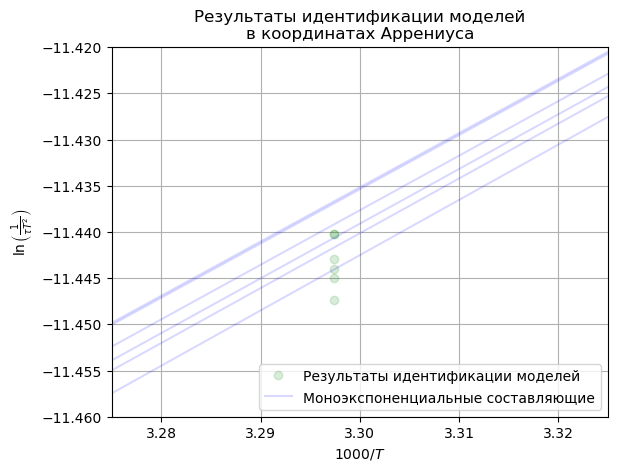

In [187]:
plt.plot(arrhenius_params[:, 1], 
         arrhenius_params[:, 0], 
         'og', 
         alpha=0.15, 
         label='Результаты идентификации моделей')

plt.plot(x, lin_regr_pred[0], '-b', alpha=0.15, label='Моноэкспоненциальные составляющие')
for y in lin_regr_pred[1:]:
    plt.plot(x, y, '-b', alpha=0.15)

plt.title('Результаты идентификации моделей\nв координатах Аррениуса')
plt.xlabel(r'$1000/T$')
plt.ylabel(r'$\ln\left(\frac{1}{\tau T^2}\right)$')

plt.xlim([3.275, 3.325])
plt.ylim([-11.46, -11.42])

plt.legend(loc='lower right')
plt.grid()

# plt.savefig(SAVES_PATH + 'arrhenius_individual_exps_lin_regr_part.pdf',
#             bbox_inches='tight')

plt.show()

In [188]:
for params in regr_points:
    lin_regr.fit(X=params[:, 1].reshape(-1, 1), y=params[:, 0].reshape(-1, 1))
    print(lin_regr.coef_, lin_regr.intercept_)

[[0.58648096]] [-13.37055976]
[[0.58641274]] [-13.37054217]
[[0.59009446]] [-13.38496497]
[[0.59165298]] [-13.39156264]
[[0.59324114]] [-13.39784204]
[[0.59803987]] [-13.41604558]


Линейная регрессия по всем точкам

In [189]:
lin_regr_all = LinearRegression()
lin_regr_all.fit(X=arrhenius_params[:, 1].reshape(-1, 1), y=arrhenius_params[:, 0].reshape(-1, 1))
lin_regr_all_pred = lin_regr_all.predict(x)

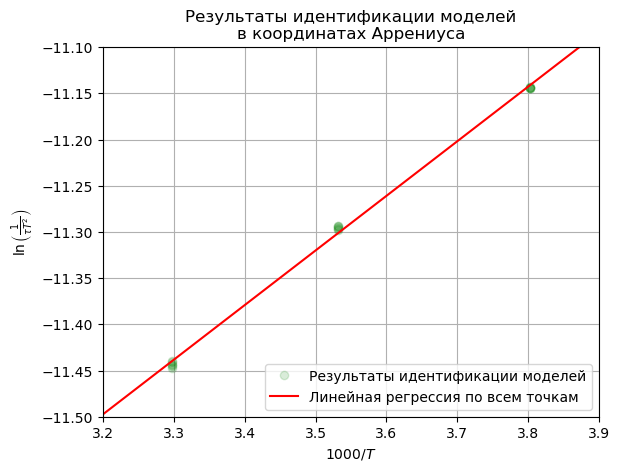

In [190]:
plt.plot(arrhenius_params[:,1], 
         arrhenius_params[:,0], 
         'og', 
         alpha=0.15, 
         label='Результаты идентификации моделей')

plt.plot(x, 
         lin_regr_all_pred,
         '-r',
         label='Линейная регрессия по всем точкам')

plt.title('Результаты идентификации моделей\nв координатах Аррениуса')
plt.xlabel(r'$1000/T$')
plt.ylabel(r'$\ln\left(\frac{1}{\tau T^2}\right)$')

plt.xlim([3.2, 3.9])
plt.ylim([-11.5, -11.1])
plt.legend(loc='lower right')
plt.grid()

# plt.savefig(SAVES_PATH + 'arrhenius_all_exps_lin_regr.pdf',
#             bbox_inches='tight')

plt.show()

In [191]:
lin_regr_all.coef_, lin_regr_all.intercept_

(array([[0.59098703]]), array([-13.38858619]))

Выполним регрессию полиномом второй степени

In [192]:
n = 2
poly_regr = Pipeline([
    ('polynomial_features', PolynomialFeatures(degree=n, include_bias=False)),
    ('scaler', StandardScaler()),
    ('linear_regresstion', LinearRegression()),
])

In [193]:
poly_regr_pred = list()

In [194]:
for params in regr_points:
    poly_regr.fit(X=params[:, 1].reshape(-1, 1), y=params[:, 0].reshape(-1, 1))
    poly_regr_pred.append(poly_regr.predict(x))

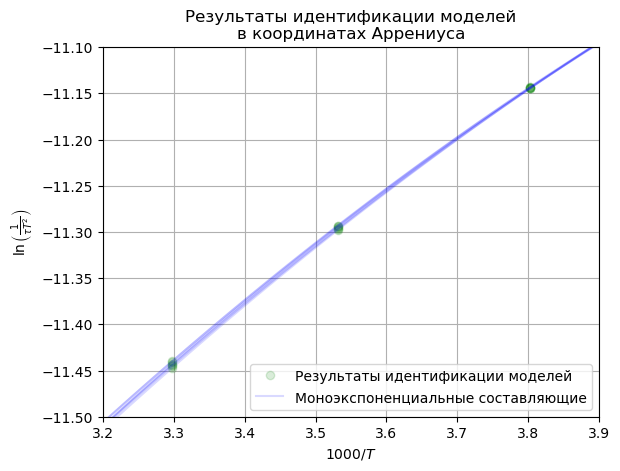

In [195]:
plt.plot(arrhenius_params[:, 1], 
         arrhenius_params[:, 0], 
         'og', 
         alpha=0.15, 
         label='Результаты идентификации моделей')

plt.plot(x, poly_regr_pred[0], '-b', alpha=0.15, label='Моноэкспоненциальные составляющие')
for y in poly_regr_pred[1:]:
    plt.plot(x, y, '-b', alpha=0.15)

plt.title('Результаты идентификации моделей\nв координатах Аррениуса')
plt.xlabel(r'$1000/T$')
plt.ylabel(r'$\ln\left(\frac{1}{\tau T^2}\right)$')

plt.xlim([3.2, 3.9])
plt.ylim([-11.5, -11.1])

plt.legend(loc='lower right')
plt.grid()

# plt.savefig(SAVES_PATH + 'arrhenius_individual_exps_poly_regr.pdf',
#             bbox_inches='tight')

plt.show()

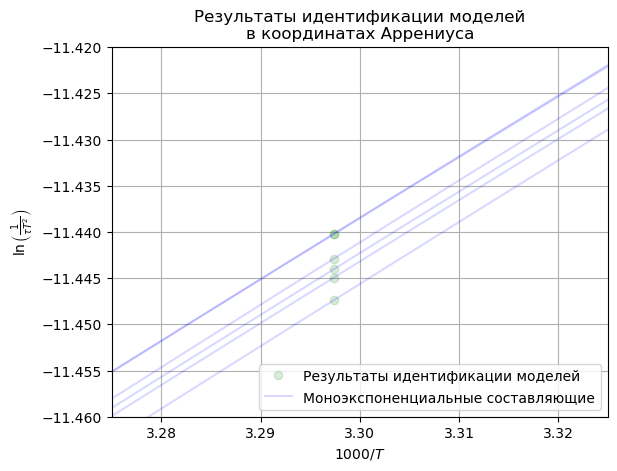

In [196]:
plt.plot(arrhenius_params[:, 1], 
         arrhenius_params[:, 0], 
         'og', 
         alpha=0.15, 
         label='Результаты идентификации моделей')

plt.plot(x, poly_regr_pred[0], '-b', alpha=0.15, label='Моноэкспоненциальные составляющие')
for y in poly_regr_pred[1:]:
    plt.plot(x, y, '-b', alpha=0.15)

plt.title('Результаты идентификации моделей\nв координатах Аррениуса')
plt.xlabel(r'$1000/T$')
plt.ylabel(r'$\ln\left(\frac{1}{\tau T^2}\right)$')

plt.xlim([3.275, 3.325])
plt.ylim([-11.46, -11.42])

plt.legend(loc='lower right')
plt.grid()

# plt.savefig(SAVES_PATH + 'arrhenius_individual_exps_poly_regr_part.pdf',
#             bbox_inches='tight')

plt.show()

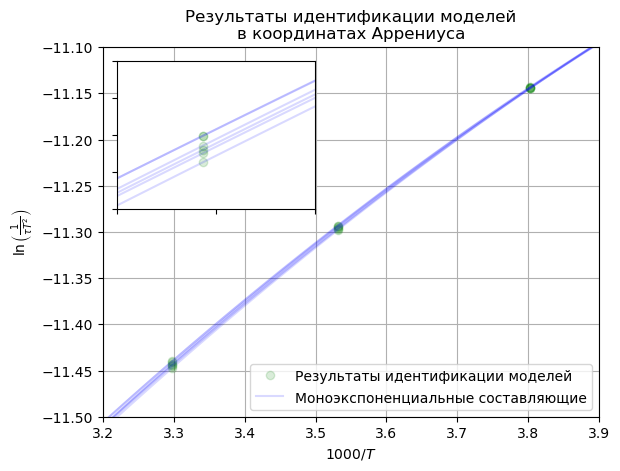

In [244]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


fig, ax = plt.subplots(1, 1,)# figsize=[9, 7])


ax.plot(arrhenius_params[:, 1], arrhenius_params[:, 0], 'og', alpha=0.15, 
        label='Результаты идентификации моделей')

ax.plot(x, poly_regr_pred[0], '-b', alpha=0.15, label='Моноэкспоненциальные составляющие')
for y in poly_regr_pred[1:]:
    ax.plot(x, y, '-b', alpha=0.15)

ax.set_title('Результаты идентификации моделей\nв координатах Аррениуса')
ax.set_xlabel(r'$1000/T$')
ax.set_ylabel(r'$\ln\left(\frac{1}{\tau T^2}\right)$')

ax.set_xlim([3.2, 3.9])
ax.set_ylim([-11.5, -11.1])

ax.legend(loc='lower right')
ax.grid()

inset = inset_axes(ax, width="40%", height="40%", loc='upper left', borderpad=1)
inset.tick_params(labelleft=False, labelbottom=False)

inset.plot(arrhenius_params[:, 1], 
         arrhenius_params[:, 0], 
         'og', 
         alpha=0.15, 
         label='Результаты идентификации моделей')

inset.plot(x, poly_regr_pred[0], '-b', alpha=0.15, label='Моноэкспоненциальные составляющие')
for y in poly_regr_pred[1:]:
    inset.plot(x, y, '-b', alpha=0.15)

inset.set_xlim([3.28, 3.32])
inset.set_ylim([-11.46, -11.42])


# plt.savefig(SAVES_PATH + 'arrhenius_poly_regr_with_inset.pdf',
#             bbox_inches='tight')


plt.show()

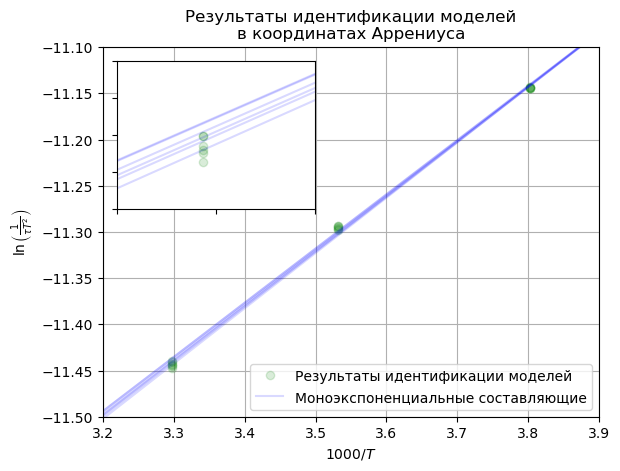

In [246]:
fig, ax = plt.subplots(1, 1,)# figsize=[9, 7])


ax.plot(arrhenius_params[:, 1], arrhenius_params[:, 0], 'og', alpha=0.15, 
        label='Результаты идентификации моделей')

ax.plot(x, lin_regr_pred[0], '-b', alpha=0.15, label='Моноэкспоненциальные составляющие')
for y in lin_regr_pred[1:]:
    ax.plot(x, y, '-b', alpha=0.15)

ax.set_title('Результаты идентификации моделей\nв координатах Аррениуса')
ax.set_xlabel(r'$1000/T$')
ax.set_ylabel(r'$\ln\left(\frac{1}{\tau T^2}\right)$')

ax.set_xlim([3.2, 3.9])
ax.set_ylim([-11.5, -11.1])

ax.legend(loc='lower right')
ax.grid()

inset = inset_axes(ax, width="40%", height="40%", loc='upper left', borderpad=1)
inset.tick_params(labelleft=False, labelbottom=False)

inset.plot(arrhenius_params[:, 1], 
         arrhenius_params[:, 0], 
         'og', 
         alpha=0.15, 
         label='Результаты идентификации моделей')

inset.plot(x, lin_regr_pred[0], '-b', alpha=0.15, label='Моноэкспоненциальные составляющие')
for y in lin_regr_pred[1:]:
    inset.plot(x, y, '-b', alpha=0.15)

inset.set_xlim([3.28, 3.32])
inset.set_ylim([-11.46, -11.42])


# plt.savefig(SAVES_PATH + 'arrhenius_lin_regr_with_inset.pdf',
#             bbox_inches='tight')


plt.show()